In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
with open('df_scaled2.pickle','rb') as f:
    df_scaled = pickle.load(f)
with open('sector.pickle','rb') as f:
    sector = pickle.load(f)

In [3]:
from datetime import date,datetime
today = date.today()
today = today.isoformat()
today = today.replace('-','')
yesterday = int(today)-1
yesterday = str(yesterday)
print(yesterday, type(yesterday))
set_d = yesterday

20220719 <class 'str'>


In [4]:
from sklearn.model_selection import train_test_split
X_train_dic = {}
X_test_dic={}
y_train_dic = {}
y_test_dic = {}
#모델이 각 업종마다 존재한다. 18개
for sector_name, df in df_scaled.items():
    # 단 셔플 없이 분할
    X_train, X_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)
    X_train_dic[sector_name] = X_train
    X_test_dic[sector_name] = X_test
    y_train_dic[sector_name] = y_train
    y_test_dic[sector_name] = y_test

In [4]:
X_train_dic['Food'].shape, y_train_dic['Food'].shape

((2400, 4), (2400,))

In [5]:
X_test_dic['Food'].shape, y_test_dic['Food'].shape

((600, 4), (600,))

# 윈도우 데이터 셋 생성

In [9]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds_y = ds_y.window(size=y_size, stride=y_stride, shift=y_shift, drop_remainder=True)
    ds_y = ds_y.flat_map(lambda y: y.batch(y_size))
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    return ds.batch(batch_size).prefetch(1)

## 파라미터 지정

In [14]:
#윈도우 사이즈
WINDOW_SIZE = 10
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 10
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = WINDOW_SIZE
y_stride = 1

batch_size = 1

In [20]:
tf_dataset_train_dic={}
for sector_name, X_train in X_train_dic.items():
    y_train = y_train_dic[sector_name]
    tf_dataset_train_dic[sector_name] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

tf_dataset_test_dic = {}
for sector_name, X_test in X_test_dic.items():
    y_test = y_test_dic[sector_name]
    tf_dataset_test_dic[sector_name] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

    # 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food'].take(3):
    print('X:', x.shape)
    print(x)
    print()
    print('Y:', y.shape)
    print(y)
    print('-'*100)

X: (1, 10, 4)
tf.Tensor(
[[[0.02383223 0.06842555 0.05423167 0.1034161 ]
  [0.01920244 0.06794263 0.05187154 0.1027709 ]
  [0.03917412 0.06308562 0.04437396 0.07655971]
  [0.04225737 0.05670212 0.0438025  0.08195749]
  [0.06395201 0.05739598 0.04494543 0.08973443]
  [0.03599058 0.06502842 0.04208812 0.095426  ]
  [0.02599399 0.07682402 0.05366021 0.10291491]
  [0.02091734 0.06884187 0.0487285  0.10399217]
  [0.0379419  0.0818198  0.05966055 0.10730457]
  [0.01763888 0.07952729 0.05323161 0.10298404]]], shape=(1, 10, 4), dtype=float64)

Y: (1, 1)
tf.Tensor([[0.07962388]], shape=(1, 1), dtype=float64)
----------------------------------------------------------------------------------------------------
X: (1, 10, 4)
tf.Tensor(
[[[0.01986691 0.05850615 0.03965941 0.09629011]
  [0.01642815 0.06356854 0.03887079 0.09088657]
  [0.01617651 0.05857276 0.03865935 0.09304683]
  [0.02629668 0.06148697 0.04708841 0.09773028]
  [0.03018051 0.06891403 0.05023144 0.10104269]
  [0.02009616 0.07196701 0.

## 모델

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
model_dic ={}
for sector_name in sector.keys():
    model_dic[sector_name] = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               #feature의 개수 3개
               input_shape=[WINDOW_SIZE, 4]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])

In [11]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_model in model_dic.values():
    sector_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [17]:
# val_loss 기준 체크포인터도 생성합니다.
filename_dic={}
for sector_name in sector.keys():
    filename_dic[sector_name] = os.path.join('tmp2', sector_name+'ckeckpointer.ckpt')

In [13]:
#체크포인트를 저장    
mc_dic = {}
for sector_name in filename_dic:
    mc_dic[sector_name] = ModelCheckpoint(filename_dic[sector_name], 
                         save_weights_only=True, 
                         save_best_only=True, 
                         monitor='val_loss', 
                         verbose=1)

In [14]:
history_dic={}
# 학습+저장
for sector_name, train_data in tf_dataset_train_dic.items():
    test_data = tf_dataset_test_dic[sector_name]
    history = model_dic[sector_name].fit(train_data, 
                        validation_data=(test_data), 
                        epochs=50, 
                        callbacks=[mc_dic[sector_name], earlystopping])
    history_dic[sector_name] = history

Epoch 1/50
239/239 [==============================] - 3s 7ms/step - loss: 0.0052 - mse: 0.0105 - val_loss: 0.0108 - val_mse: 0.0216

Epoch 00001: val_loss improved from inf to 0.01078, saving model to tmp2\Foodckeckpointer.ckpt
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 0.0033 - val_mse: 0.0067

Epoch 00002: val_loss improved from 0.01078 to 0.00333, saving model to tmp2\Foodckeckpointer.ckpt
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0023 - val_loss: 0.0021 - val_mse: 0.0042

Epoch 00003: val_loss improved from 0.00333 to 0.00210, saving model to tmp2\Foodckeckpointer.ckpt
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0028 - val_mse: 0.0056

Epoch 00004: val_loss did not improve from 0.00210
Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 8.9503e-04 - mse: 0.0018 - val_loss: 0.0014 - val_


Epoch 00038: val_loss did not improve from 0.00040
Epoch 39/50
239/239 [==============================] - 1s 5ms/step - loss: 5.0210e-04 - mse: 0.0010 - val_loss: 4.6453e-04 - val_mse: 9.2907e-04

Epoch 00039: val_loss did not improve from 0.00040
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 4.9159e-04 - mse: 9.8318e-04 - val_loss: 4.5175e-04 - val_mse: 9.0351e-04

Epoch 00040: val_loss did not improve from 0.00040
Epoch 41/50
239/239 [==============================] - 1s 5ms/step - loss: 4.7901e-04 - mse: 9.5802e-04 - val_loss: 4.6052e-04 - val_mse: 9.2105e-04

Epoch 00041: val_loss did not improve from 0.00040
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 4.7058e-04 - mse: 9.4115e-04 - val_loss: 4.2599e-04 - val_mse: 8.5199e-04

Epoch 00042: val_loss did not improve from 0.00040
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 4.6225e-04 - mse: 9.2450e-04 - val_loss: 4.2037e-04 - val_mse: 8.4075e-04

239/239 [==============================] - 1s 6ms/step - loss: 2.4078e-04 - mse: 4.8157e-04 - val_loss: 0.0328 - val_mse: 0.0655

Epoch 00027: val_loss improved from 0.03288 to 0.03275, saving model to tmp2\Clothingckeckpointer.ckpt
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 2.3754e-04 - mse: 4.7507e-04 - val_loss: 0.0324 - val_mse: 0.0648

Epoch 00028: val_loss improved from 0.03275 to 0.03238, saving model to tmp2\Clothingckeckpointer.ckpt
Epoch 29/50
239/239 [==============================] - 1s 5ms/step - loss: 2.3563e-04 - mse: 4.7126e-04 - val_loss: 0.0321 - val_mse: 0.0642

Epoch 00029: val_loss improved from 0.03238 to 0.03209, saving model to tmp2\Clothingckeckpointer.ckpt
Epoch 30/50
239/239 [==============================] - 1s 5ms/step - loss: 2.3074e-04 - mse: 4.6149e-04 - val_loss: 0.0325 - val_mse: 0.0649

Epoch 00030: val_loss did not improve from 0.03209
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 2.2726e-0

Epoch 12/50
239/239 [==============================] - 1s 5ms/step - loss: 4.3945e-04 - mse: 8.7889e-04 - val_loss: 0.0165 - val_mse: 0.0331

Epoch 00012: val_loss improved from 0.01699 to 0.01655, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 13/50
239/239 [==============================] - 1s 5ms/step - loss: 4.3224e-04 - mse: 8.6448e-04 - val_loss: 0.0160 - val_mse: 0.0321

Epoch 00013: val_loss improved from 0.01655 to 0.01605, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 14/50
239/239 [==============================] - 1s 5ms/step - loss: 4.2214e-04 - mse: 8.4429e-04 - val_loss: 0.0157 - val_mse: 0.0314

Epoch 00014: val_loss improved from 0.01605 to 0.01570, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 4.0907e-04 - mse: 8.1815e-04 - val_loss: 0.0153 - val_mse: 0.0306

Epoch 00015: val_loss improved from 0.01570 to 0.01530, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 16/50
239/239 


Epoch 00045: val_loss improved from 0.00916 to 0.00894, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 2.2985e-04 - mse: 4.5971e-04 - val_loss: 0.0087 - val_mse: 0.0175

Epoch 00046: val_loss improved from 0.00894 to 0.00873, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 2.2026e-04 - mse: 4.4052e-04 - val_loss: 0.0084 - val_mse: 0.0169

Epoch 00047: val_loss improved from 0.00873 to 0.00843, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 48/50
239/239 [==============================] - 1s 6ms/step - loss: 2.1490e-04 - mse: 4.2979e-04 - val_loss: 0.0081 - val_mse: 0.0163

Epoch 00048: val_loss improved from 0.00843 to 0.00814, saving model to tmp2\Chemicalckeckpointer.ckpt
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 2.0964e-04 - mse: 4.1928e-04 - val_loss: 0.0078 - val_mse: 0.0157

Epoch 00049: val_lo

239/239 [==============================] - 1s 5ms/step - loss: 5.8666e-04 - mse: 0.0012 - val_loss: 0.0142 - val_mse: 0.0283

Epoch 00030: val_loss improved from 0.01438 to 0.01415, saving model to tmp2\Medicineckeckpointer.ckpt
Epoch 31/50
239/239 [==============================] - 1s 5ms/step - loss: 5.7858e-04 - mse: 0.0012 - val_loss: 0.0139 - val_mse: 0.0278

Epoch 00031: val_loss improved from 0.01415 to 0.01391, saving model to tmp2\Medicineckeckpointer.ckpt
Epoch 32/50
239/239 [==============================] - 1s 5ms/step - loss: 5.6548e-04 - mse: 0.0011 - val_loss: 0.0135 - val_mse: 0.0270

Epoch 00032: val_loss improved from 0.01391 to 0.01348, saving model to tmp2\Medicineckeckpointer.ckpt
Epoch 33/50
239/239 [==============================] - 1s 6ms/step - loss: 5.5433e-04 - mse: 0.0011 - val_loss: 0.0135 - val_mse: 0.0270

Epoch 00033: val_loss did not improve from 0.01348
Epoch 34/50
239/239 [==============================] - 1s 5ms/step - loss: 5.5151e-04 - mse: 0.0011 


Epoch 00049: val_loss did not improve from 0.01245
Epoch 50/50
239/239 [==============================] - 1s 5ms/step - loss: 9.2631e-05 - mse: 1.8526e-04 - val_loss: 0.0176 - val_mse: 0.0353

Epoch 00050: val_loss did not improve from 0.01245
Epoch 1/50
239/239 [==============================] - 3s 7ms/step - loss: 0.0085 - mse: 0.0170 - val_loss: 0.0037 - val_mse: 0.0074

Epoch 00001: val_loss improved from inf to 0.00368, saving model to tmp2\Metalckeckpointer.ckpt
Epoch 2/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0014 - val_mse: 0.0028

Epoch 00002: val_loss improved from 0.00368 to 0.00139, saving model to tmp2\Metalckeckpointer.ckpt
Epoch 3/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0043 - mse: 0.0086 - val_loss: 7.4812e-04 - val_mse: 0.0015

Epoch 00003: val_loss improved from 0.00139 to 0.00075, saving model to tmp2\Metalckeckpointer.ckpt
Epoch 4/50
239/239 [==============================] - 1s


Epoch 00020: val_loss improved from 0.00940 to 0.00927, saving model to tmp2\Machineckeckpointer.ckpt
Epoch 21/50
239/239 [==============================] - 1s 6ms/step - loss: 4.9352e-04 - mse: 9.8703e-04 - val_loss: 0.0092 - val_mse: 0.0183

Epoch 00021: val_loss improved from 0.00927 to 0.00917, saving model to tmp2\Machineckeckpointer.ckpt
Epoch 22/50
239/239 [==============================] - 1s 5ms/step - loss: 4.8752e-04 - mse: 9.7505e-04 - val_loss: 0.0091 - val_mse: 0.0181

Epoch 00022: val_loss improved from 0.00917 to 0.00905, saving model to tmp2\Machineckeckpointer.ckpt
Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 4.8117e-04 - mse: 9.6233e-04 - val_loss: 0.0089 - val_mse: 0.0178

Epoch 00023: val_loss improved from 0.00905 to 0.00890, saving model to tmp2\Machineckeckpointer.ckpt
Epoch 24/50
239/239 [==============================] - 1s 5ms/step - loss: 4.7204e-04 - mse: 9.4407e-04 - val_loss: 0.0088 - val_mse: 0.0177

Epoch 00024: val_loss i

239/239 [==============================] - 1s 5ms/step - loss: 1.4951e-04 - mse: 2.9901e-04 - val_loss: 0.0765 - val_mse: 0.1531

Epoch 00005: val_loss did not improve from 0.07346
Epoch 6/50
239/239 [==============================] - 1s 5ms/step - loss: 1.0340e-04 - mse: 2.0679e-04 - val_loss: 0.0735 - val_mse: 0.1471

Epoch 00006: val_loss did not improve from 0.07346
Epoch 7/50
239/239 [==============================] - 1s 5ms/step - loss: 8.3998e-05 - mse: 1.6800e-04 - val_loss: 0.0695 - val_mse: 0.1390

Epoch 00007: val_loss improved from 0.07346 to 0.06948, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 8/50
239/239 [==============================] - 1s 5ms/step - loss: 7.5603e-05 - mse: 1.5121e-04 - val_loss: 0.0688 - val_mse: 0.1375

Epoch 00008: val_loss improved from 0.06948 to 0.06877, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 6.9716e-05 - mse: 1.3943e-04 - val_loss: 0.0659 - val_mse: 0.

Epoch 39/50
239/239 [==============================] - 2s 8ms/step - loss: 3.9102e-05 - mse: 7.8204e-05 - val_loss: 0.0210 - val_mse: 0.0420

Epoch 00039: val_loss improved from 0.02187 to 0.02098, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 40/50
239/239 [==============================] - 2s 7ms/step - loss: 3.8600e-05 - mse: 7.7201e-05 - val_loss: 0.0199 - val_mse: 0.0399

Epoch 00040: val_loss improved from 0.02098 to 0.01995, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 41/50
239/239 [==============================] - 1s 6ms/step - loss: 3.8221e-05 - mse: 7.6442e-05 - val_loss: 0.0193 - val_mse: 0.0385

Epoch 00041: val_loss improved from 0.01995 to 0.01925, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 3.8023e-05 - mse: 7.6047e-05 - val_loss: 0.0183 - val_mse: 0.0365

Epoch 00042: val_loss improved from 0.01925 to 0.01825, saving model to tmp2\Electronicckeckpointer.ckpt
Epoch 43/50



Epoch 00023: val_loss did not improve from 0.00023
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 2.3637e-04 - val_mse: 4.7273e-04

Epoch 00024: val_loss did not improve from 0.00023
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 2.3451e-04 - val_mse: 4.6902e-04

Epoch 00025: val_loss did not improve from 0.00023
Epoch 26/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 2.3728e-04 - val_mse: 4.7455e-04

Epoch 00026: val_loss did not improve from 0.00023
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 2.3696e-04 - val_mse: 4.7391e-04

Epoch 00027: val_loss did not improve from 0.00023
Epoch 28/50
239/239 [==============================] - 1s 5ms/step - loss: 9.8376e-04 - mse: 0.0020 - val_loss: 2.3955e-04 - val_mse: 4.7911e-04

Epoch 00028: val_loss did not 

Epoch 5/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0034 - mse: 0.0068 - val_loss: 2.7364e-04 - val_mse: 5.4728e-04

Epoch 00005: val_loss did not improve from 0.00026
Epoch 6/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0029 - mse: 0.0057 - val_loss: 2.6982e-04 - val_mse: 5.3965e-04

Epoch 00006: val_loss did not improve from 0.00026
Epoch 7/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0030 - mse: 0.0060 - val_loss: 2.5671e-04 - val_mse: 5.1341e-04

Epoch 00007: val_loss improved from 0.00026 to 0.00026, saving model to tmp2\Distributionckeckpointer.ckpt
Epoch 8/50
239/239 [==============================] - 1s 6ms/step - loss: 0.0030 - mse: 0.0059 - val_loss: 2.6070e-04 - val_mse: 5.2140e-04

Epoch 00008: val_loss did not improve from 0.00026
Epoch 9/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0028 - mse: 0.0057 - val_loss: 2.2051e-04 - val_mse: 4.4101e-04

Epoch 00009: val_loss improved from

Epoch 23/50
239/239 [==============================] - 1s 6ms/step - loss: 3.1707e-04 - mse: 6.3413e-04 - val_loss: 0.0084 - val_mse: 0.0169

Epoch 00023: val_loss improved from 0.00879 to 0.00844, saving model to tmp2\Powerckeckpointer.ckpt
Epoch 24/50
239/239 [==============================] - 2s 6ms/step - loss: 3.0841e-04 - mse: 6.1683e-04 - val_loss: 0.0081 - val_mse: 0.0162

Epoch 00024: val_loss improved from 0.00844 to 0.00809, saving model to tmp2\Powerckeckpointer.ckpt
Epoch 25/50
239/239 [==============================] - 1s 6ms/step - loss: 2.9864e-04 - mse: 5.9728e-04 - val_loss: 0.0077 - val_mse: 0.0155

Epoch 00025: val_loss improved from 0.00809 to 0.00774, saving model to tmp2\Powerckeckpointer.ckpt
Epoch 26/50
239/239 [==============================] - 1s 6ms/step - loss: 2.8948e-04 - mse: 5.7896e-04 - val_loss: 0.0074 - val_mse: 0.0149

Epoch 00026: val_loss improved from 0.00774 to 0.00743, saving model to tmp2\Powerckeckpointer.ckpt
Epoch 27/50
239/239 [===========

239/239 [==============================] - 1s 5ms/step - loss: 3.7323e-04 - mse: 7.4646e-04 - val_loss: 0.0016 - val_mse: 0.0033

Epoch 00043: val_loss did not improve from 0.00154
Epoch 44/50
239/239 [==============================] - 1s 5ms/step - loss: 3.4001e-04 - mse: 6.8001e-04 - val_loss: 0.0014 - val_mse: 0.0029

Epoch 00044: val_loss improved from 0.00154 to 0.00144, saving model to tmp2\Teleckeckpointer.ckpt
Epoch 45/50
239/239 [==============================] - 1s 5ms/step - loss: 3.2796e-04 - mse: 6.5592e-04 - val_loss: 0.0013 - val_mse: 0.0027

Epoch 00045: val_loss improved from 0.00144 to 0.00134, saving model to tmp2\Teleckeckpointer.ckpt
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 3.2082e-04 - mse: 6.4163e-04 - val_loss: 0.0013 - val_mse: 0.0026

Epoch 00046: val_loss improved from 0.00134 to 0.00131, saving model to tmp2\Teleckeckpointer.ckpt
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 3.1492e-04 - mse: 6.2

Epoch 12/50
239/239 [==============================] - 1s 6ms/step - loss: 5.4397e-04 - mse: 0.0011 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00012: val_loss improved from 0.00191 to 0.00182, saving model to tmp2\Brokerageckeckpointer.ckpt
Epoch 13/50
239/239 [==============================] - 1s 6ms/step - loss: 5.2934e-04 - mse: 0.0011 - val_loss: 0.0017 - val_mse: 0.0034

Epoch 00013: val_loss improved from 0.00182 to 0.00170, saving model to tmp2\Brokerageckeckpointer.ckpt
Epoch 14/50
239/239 [==============================] - 2s 6ms/step - loss: 5.1163e-04 - mse: 0.0010 - val_loss: 0.0017 - val_mse: 0.0033

Epoch 00014: val_loss improved from 0.00170 to 0.00166, saving model to tmp2\Brokerageckeckpointer.ckpt
Epoch 15/50
239/239 [==============================] - 1s 6ms/step - loss: 5.0165e-04 - mse: 0.0010 - val_loss: 0.0017 - val_mse: 0.0033

Epoch 00015: val_loss improved from 0.00166 to 0.00165, saving model to tmp2\Brokerageckeckpointer.ckpt
Epoch 16/50
239/239 [===========

239/239 [==============================] - 1s 5ms/step - loss: 6.5580e-04 - mse: 0.0013 - val_loss: 6.2159e-04 - val_mse: 0.0012

Epoch 00039: val_loss improved from 0.00064 to 0.00062, saving model to tmp2\Insurerckeckpointer.ckpt
Epoch 40/50
239/239 [==============================] - 1s 5ms/step - loss: 6.4297e-04 - mse: 0.0013 - val_loss: 6.0264e-04 - val_mse: 0.0012

Epoch 00040: val_loss improved from 0.00062 to 0.00060, saving model to tmp2\Insurerckeckpointer.ckpt
Epoch 41/50
239/239 [==============================] - 1s 6ms/step - loss: 6.3173e-04 - mse: 0.0013 - val_loss: 5.8388e-04 - val_mse: 0.0012

Epoch 00041: val_loss improved from 0.00060 to 0.00058, saving model to tmp2\Insurerckeckpointer.ckpt
Epoch 42/50
239/239 [==============================] - 1s 5ms/step - loss: 6.2171e-04 - mse: 0.0012 - val_loss: 5.6936e-04 - val_mse: 0.0011

Epoch 00042: val_loss improved from 0.00058 to 0.00057, saving model to tmp2\Insurerckeckpointer.ckpt
Epoch 43/50
239/239 [===============

239/239 [==============================] - 1s 5ms/step - loss: 1.0457e-04 - mse: 2.0914e-04 - val_loss: 0.0062 - val_mse: 0.0123

Epoch 00023: val_loss improved from 0.00637 to 0.00615, saving model to tmp2\Serviceckeckpointer.ckpt
Epoch 24/50
239/239 [==============================] - 1s 6ms/step - loss: 1.0367e-04 - mse: 2.0735e-04 - val_loss: 0.0060 - val_mse: 0.0119

Epoch 00024: val_loss improved from 0.00615 to 0.00596, saving model to tmp2\Serviceckeckpointer.ckpt
Epoch 25/50
239/239 [==============================] - 1s 5ms/step - loss: 1.0135e-04 - mse: 2.0269e-04 - val_loss: 0.0060 - val_mse: 0.0119

Epoch 00025: val_loss improved from 0.00596 to 0.00595, saving model to tmp2\Serviceckeckpointer.ckpt
Epoch 26/50
239/239 [==============================] - 1s 6ms/step - loss: 9.9441e-05 - mse: 1.9888e-04 - val_loss: 0.0061 - val_mse: 0.0123

Epoch 00026: val_loss did not improve from 0.00595
Epoch 27/50
239/239 [==============================] - 1s 5ms/step - loss: 9.6488e-05 -

239/239 [==============================] - 1s 5ms/step - loss: 8.1981e-04 - mse: 0.0016 - val_loss: 0.0063 - val_mse: 0.0126

Epoch 00011: val_loss improved from 0.00665 to 0.00628, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 12/50
239/239 [==============================] - 2s 7ms/step - loss: 7.8061e-04 - mse: 0.0016 - val_loss: 0.0059 - val_mse: 0.0117

Epoch 00012: val_loss improved from 0.00628 to 0.00586, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 13/50
239/239 [==============================] - 2s 6ms/step - loss: 7.4875e-04 - mse: 0.0015 - val_loss: 0.0055 - val_mse: 0.0110

Epoch 00013: val_loss improved from 0.00586 to 0.00551, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 14/50
239/239 [==============================] - 1s 6ms/step - loss: 7.2246e-04 - mse: 0.0014 - val_loss: 0.0052 - val_mse: 0.0105

Epoch 00014: val_loss improved from 0.00551 to 0.00523, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 15/50
239/239 [===========

Epoch 45/50
239/239 [==============================] - 2s 6ms/step - loss: 3.4402e-04 - mse: 6.8804e-04 - val_loss: 0.0018 - val_mse: 0.0036

Epoch 00045: val_loss improved from 0.00187 to 0.00180, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 46/50
239/239 [==============================] - 1s 6ms/step - loss: 3.3671e-04 - mse: 6.7343e-04 - val_loss: 0.0021 - val_mse: 0.0041

Epoch 00046: val_loss did not improve from 0.00180
Epoch 47/50
239/239 [==============================] - 1s 5ms/step - loss: 3.2470e-04 - mse: 6.4941e-04 - val_loss: 0.0018 - val_mse: 0.0037

Epoch 00047: val_loss did not improve from 0.00180
Epoch 48/50
239/239 [==============================] - 1s 5ms/step - loss: 3.1427e-04 - mse: 6.2854e-04 - val_loss: 0.0016 - val_mse: 0.0032

Epoch 00048: val_loss improved from 0.00180 to 0.00159, saving model to tmp2\Manufacturerckeckpointer.ckpt
Epoch 49/50
239/239 [==============================] - 1s 5ms/step - loss: 3.0286e-04 - mse: 6.0572e-04 - val_loss: 

In [18]:
load_model_checkpoint={}
for sector_name, sector_model in filename_dic.items():
    load_model_checkpoint[sector_name] = model_dic[sector_name].load_weights(filename_dic[sector_name])

Food의 test_data의 출력 크기 :  (59, 1)


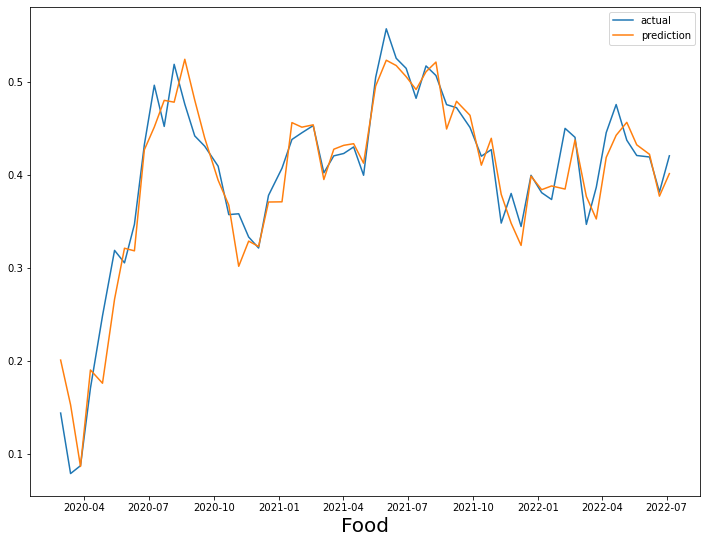

Clothing의 test_data의 출력 크기 :  (59, 1)


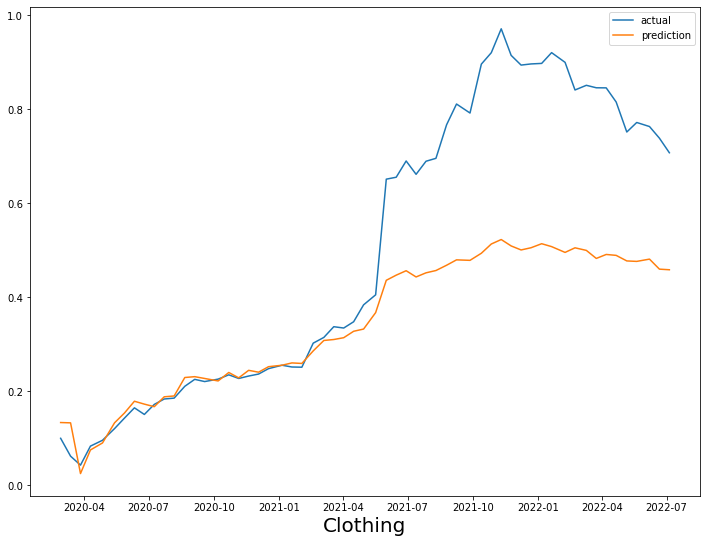

Chemical의 test_data의 출력 크기 :  (59, 1)


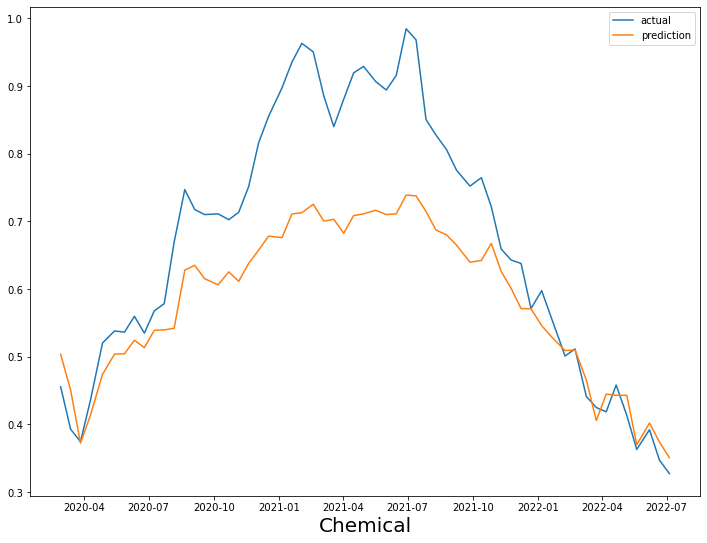

Medicine의 test_data의 출력 크기 :  (59, 1)


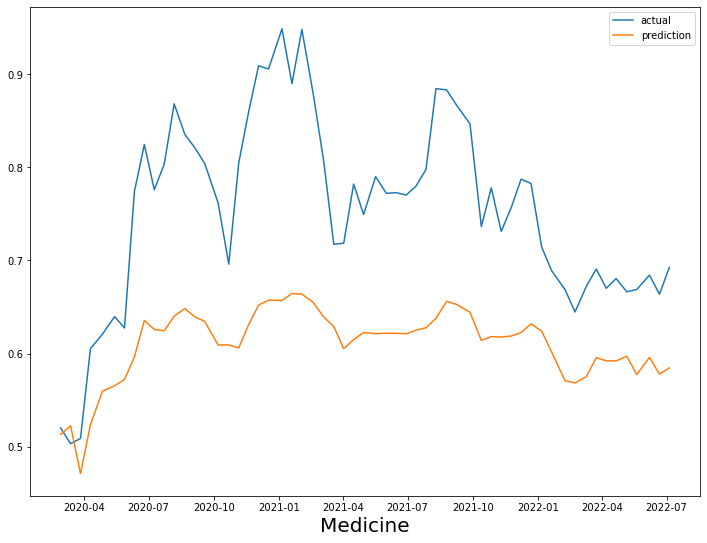

Non_Metal의 test_data의 출력 크기 :  (59, 1)


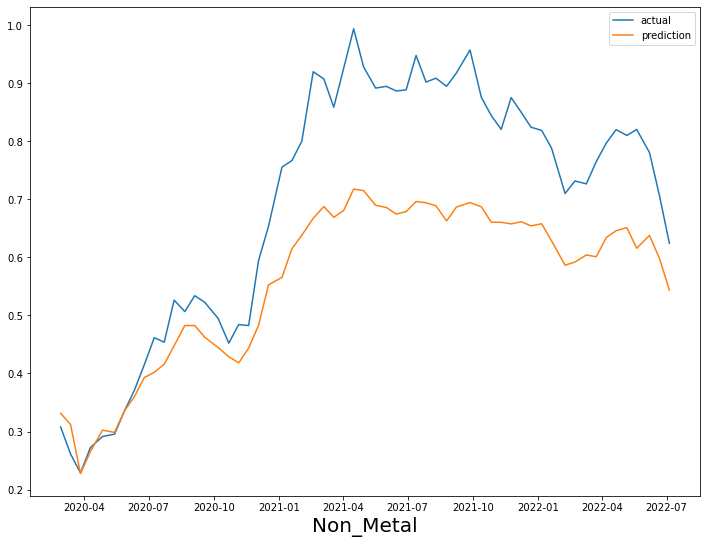

Metal의 test_data의 출력 크기 :  (59, 1)


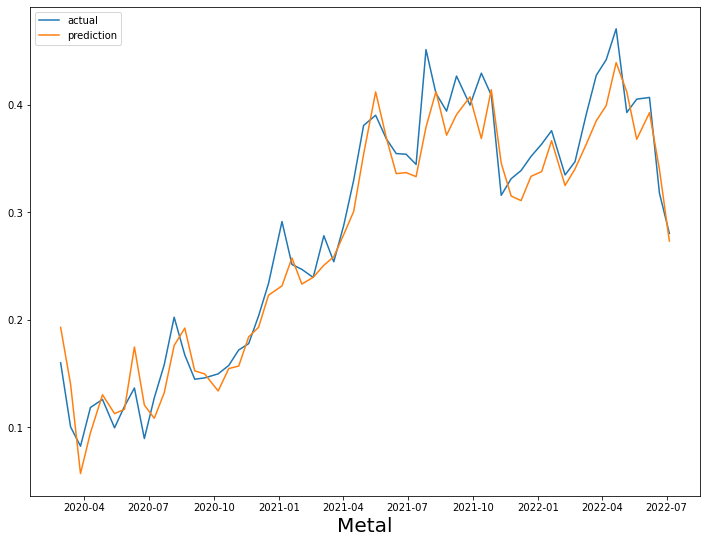

Machine의 test_data의 출력 크기 :  (59, 1)


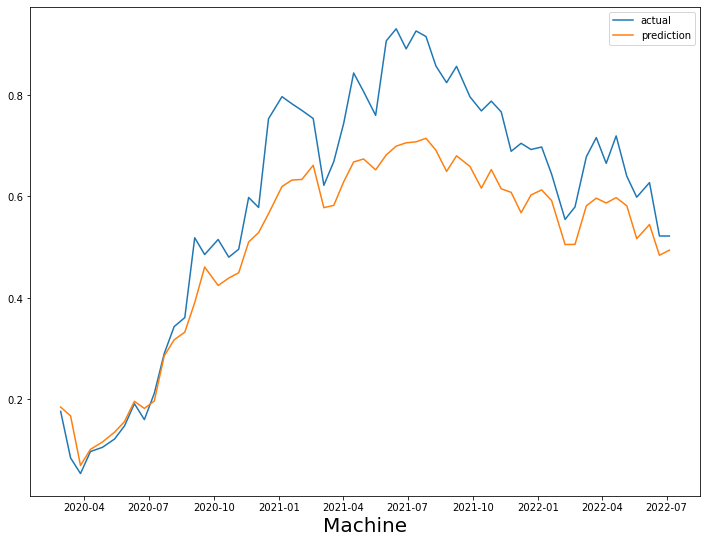

Electronic의 test_data의 출력 크기 :  (59, 1)


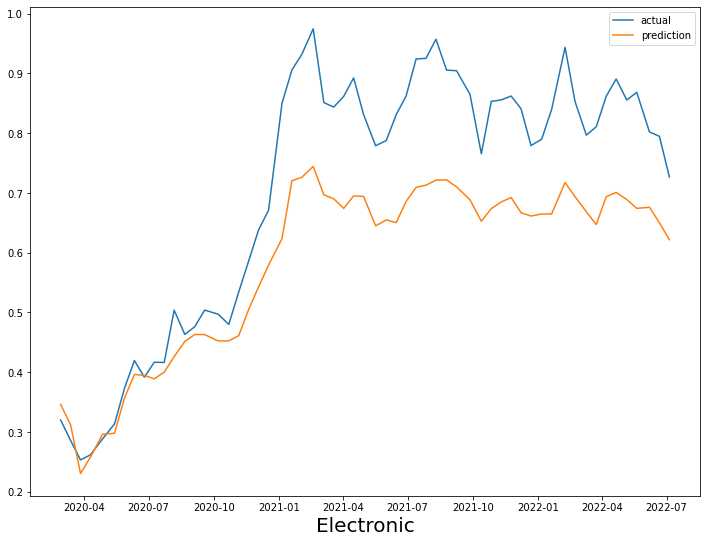

Construction의 test_data의 출력 크기 :  (59, 1)


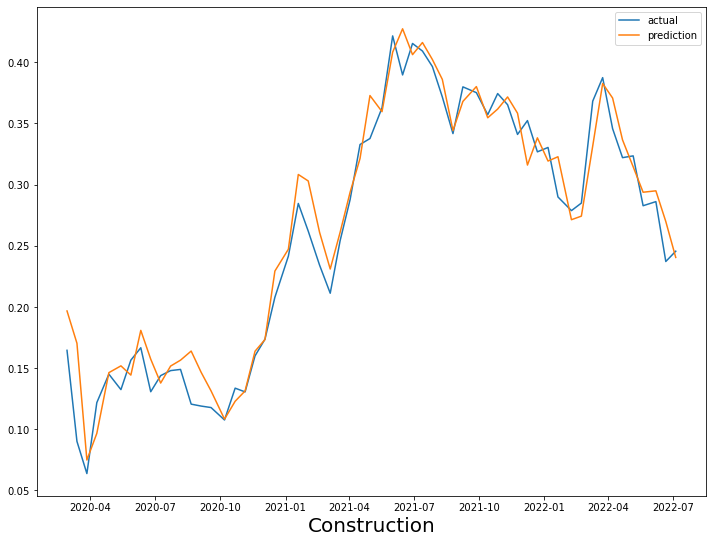

Transport의 test_data의 출력 크기 :  (59, 1)


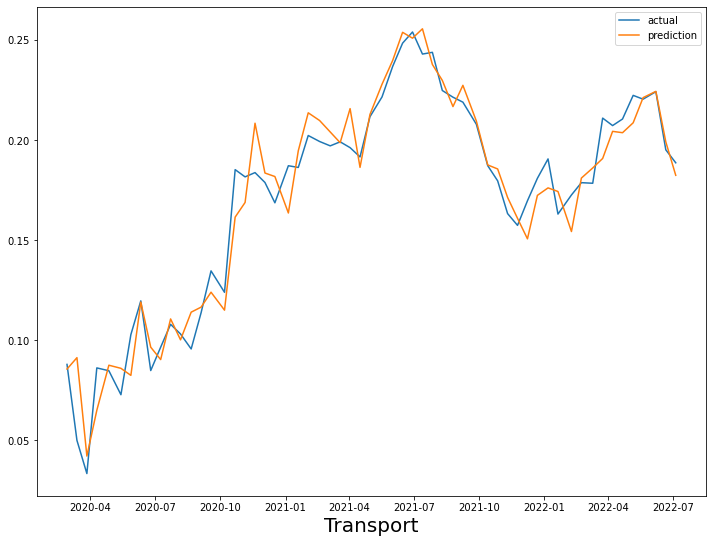

Distribution의 test_data의 출력 크기 :  (59, 1)


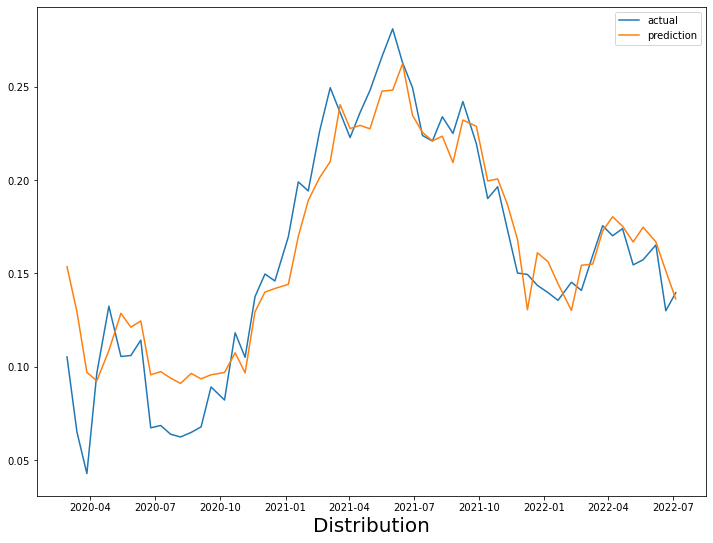

Power의 test_data의 출력 크기 :  (59, 1)


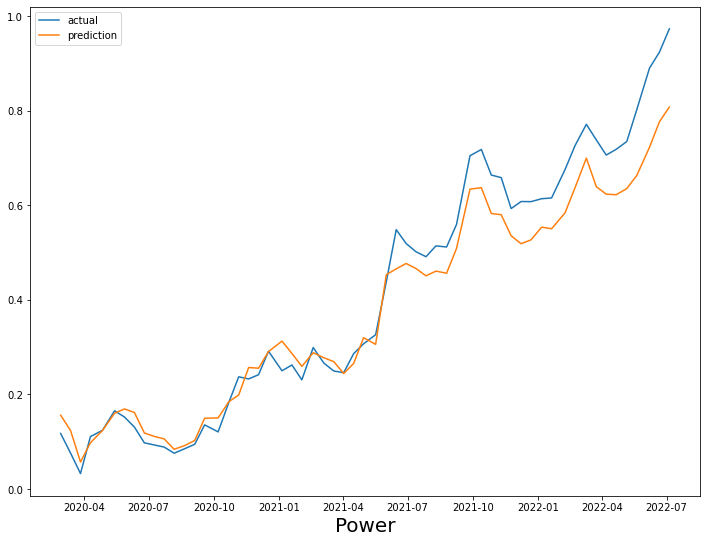

Tele의 test_data의 출력 크기 :  (59, 1)


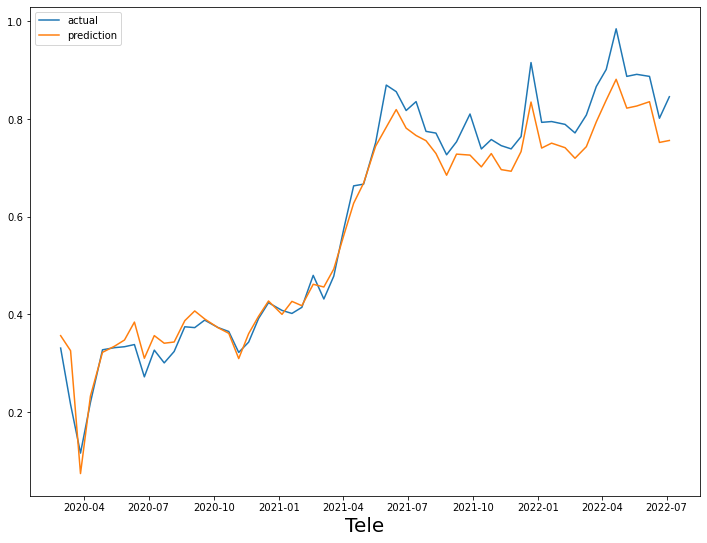

Finance의 test_data의 출력 크기 :  (59, 1)


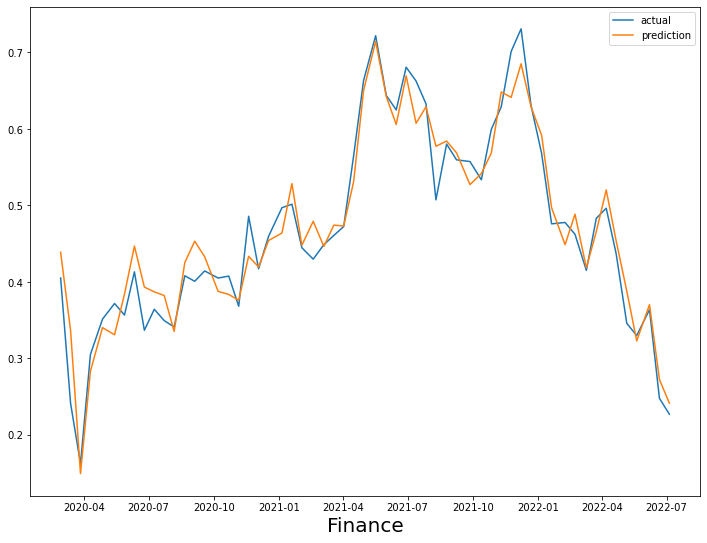

Brokerage의 test_data의 출력 크기 :  (59, 1)


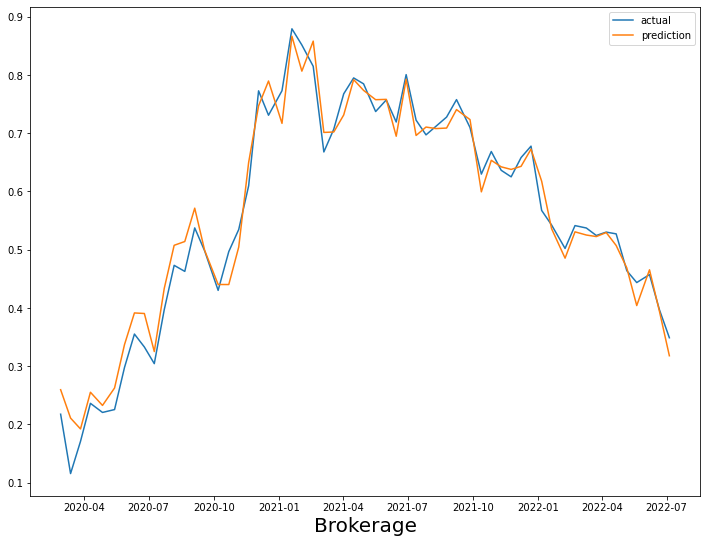

Insurer의 test_data의 출력 크기 :  (59, 1)


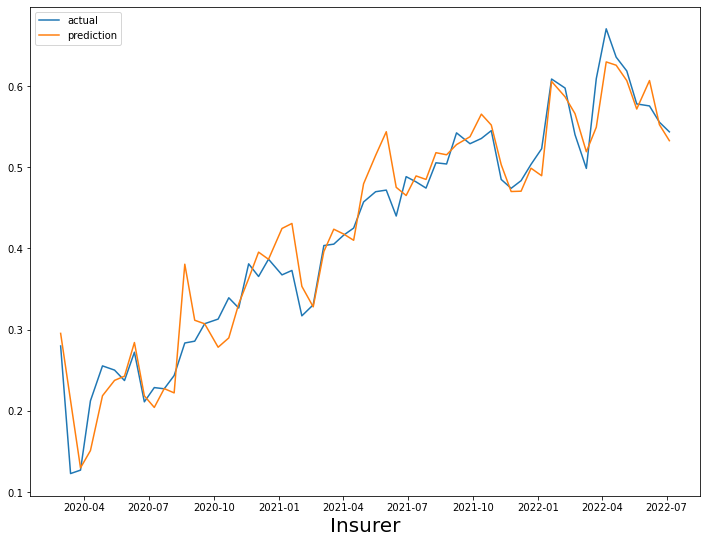

Service의 test_data의 출력 크기 :  (59, 1)


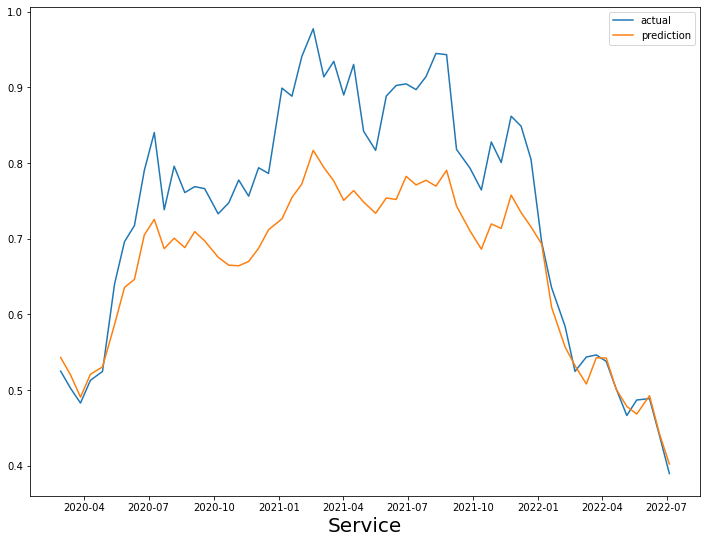

Manufacturer의 test_data의 출력 크기 :  (59, 1)


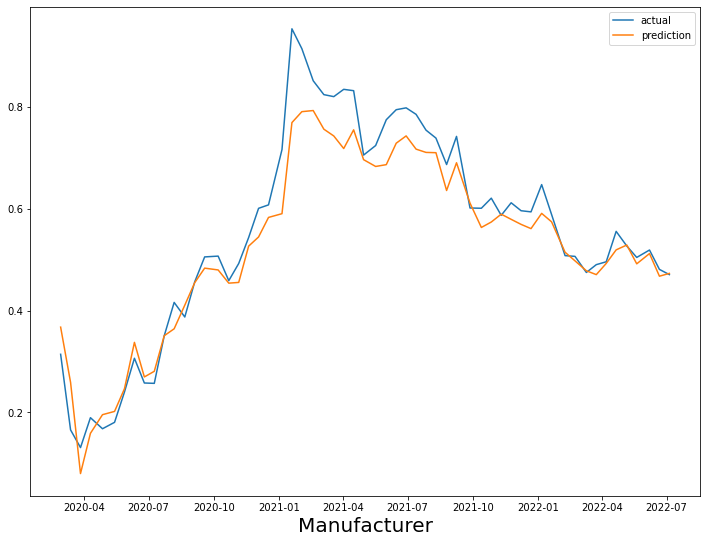

In [21]:
for sector_name, model in model_dic.items():
    df_일자 = pd.DataFrame(data=y_test_dic[sector_name].index)[10::10]
    pred = model.predict(tf_dataset_test_dic[sector_name])
    print(f'{sector_name}의 test_data의 출력 크기 : ' ,pred.shape)
    plt.figure(figsize=(12, 9))
    plt.xlabel(sector_name, fontdict={'size': 20})
    plt.plot(df_일자,np.asarray(y_test_dic[sector_name])[10::10], label='actual')
    plt.plot(df_일자,pred, label='prediction')
    plt.legend()
    plt.show()

# today 업종 상향 / 하향 예측하기

In [22]:
for sector_name, model in model_dic.items():
    pred_l = []
    for i in range(6):
        data = tf.constant(np.expand_dims(np.array(X_test_dic[sector_name].tail(10+i)[:10]),axis=0))
        pred_l.append(float(model.predict(data)))
    pre = sum(pred_l[1:])/5
    if pred_l[0]>pre:
        print(f'{sector_name} 업종은 상향을 예상합니다.')
    elif pred_l[0]<pre:
        print(f'{sector_name} 업종은 하향을 예상합니다.')

Food 업종은 하향을 예상합니다.
Clothing 업종은 하향을 예상합니다.
Chemical 업종은 상향을 예상합니다.
Medicine 업종은 상향을 예상합니다.
Non_Metal 업종은 상향을 예상합니다.
Metal 업종은 하향을 예상합니다.
Machine 업종은 하향을 예상합니다.
Electronic 업종은 상향을 예상합니다.
Construction 업종은 하향을 예상합니다.
Transport 업종은 하향을 예상합니다.
Distribution 업종은 하향을 예상합니다.
Power 업종은 하향을 예상합니다.
Tele 업종은 하향을 예상합니다.
Finance 업종은 상향을 예상합니다.
Brokerage 업종은 하향을 예상합니다.
Insurer 업종은 하향을 예상합니다.
Service 업종은 하향을 예상합니다.
Manufacturer 업종은 상향을 예상합니다.
